In [1]:
import sys
sys.path.append("/home/luke/Programs/uw2_dev")

%matplotlib inline

import underworld as uw
import glucifer.pylab as plt
import underworld.function as fn
from libUnderworld import petsc

from math import sin, cos
import numpy as np
import matplotlib.pyplot as mplt
import matplotlib.pylab as pylab
from matplotlib.colors import LogNorm
import time


dim = 2

ires = 104
jres = 48
ires = 104*2
jres = 48*2

xmin, xmax = -200e3, 200e3
ymin, ymax = -160e3, 15e3

elementMesh = uw.mesh.FeMesh_Cartesian(elementType = 'Q1/dQ0', 
                                       elementRes = (ires, jres), 
                                       minCoord = (xmin, ymin), 
                                       maxCoord = (xmax, ymax))
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

velocityField = uw.fevariable.FeVariable(feMesh = linearMesh, nodeDofCount = dim)
pressureField = uw.fevariable.FeVariable(feMesh = constantMesh, nodeDofCount = 1)
temperatureField = uw.fevariable.FeVariable(feMesh = linearMesh, nodeDofCount = 1)
strainRateInvField = uw.fevariable.FeVariable(feMesh = linearMesh, nodeDofCount = 1)

swarm = uw.swarm.Swarm(linearMesh, particleEscape = True)

material_index = swarm.add_variable('char', 1)
visc = swarm.add_variable('double', 1)

# Fill the mesh with particles
layout = uw.swarm.layouts.GlobalSpaceFillerLayout(swarm, 40)
swarm.populate_using_layout(layout)

# create some misc shapes
coord = fn.input()

# create some misc shapes
airShape = (coord[1] <= 15e3) & (coord[1] > 0.)
upperShape = (coord[1] <= 0.) & (coord[1] > -20e3)
lowerShape = (coord[1] <= -20e3) & (coord[1] > -40e3)
mantleShape = (coord[1] <= -40e3) & (coord[1] >= -160e3)
notchShape = (coord[1] <= -15e3) & (coord[1] > -20e3) & (coord[0] >= -10e3) & (coord[0] <= 10e3)

airIndex = 1
uppercrustIndex = 2
lowercrustIndex = 3
mantleIndex = 4
notchIndex = 5

material_index.data[:] = fn.branching.conditional(
    [ #  Which ever condition returns True first is used (hence why notchShape is before upperShape)
        (mantleShape, mantleIndex),
        (lowerShape, lowercrustIndex),
        (notchShape, notchIndex),
        (upperShape, uppercrustIndex),
        (airShape, airIndex),
        (True, -1),
    ]).evaluate(swarm)

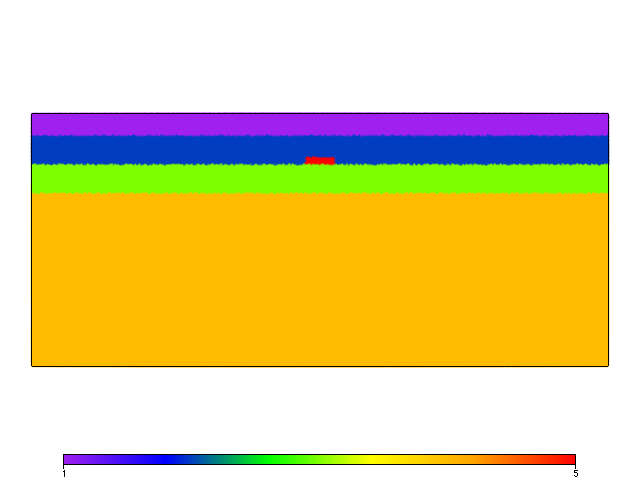

In [2]:
fig = plt.Figure()
fig.Points(swarm, material_index, pointSize=4.0)
fig.show()

In [3]:
# single value to be used for all materials
thermal_exp = 5e-3
diffusivity = 1e-6

# dictionary to map out value for each material
radiogenic_heat_map = {airIndex: 0., 
                       uppercrustIndex: 1.2e-6, 
                       notchIndex: 1.2e-5, 
                       lowercrustIndex: 0.6e-6,
                       mantleIndex: 0.02e-6,}

heat_capacity_map = {airIndex: 1000., 
                     uppercrustIndex: 1000., 
                     notchIndex: 1000., 
                     lowercrustIndex: 1000.,
                     mantleIndex: 1000.,}

density_map = {airIndex: 1., 
               uppercrustIndex: 2800., 
               notchIndex: 2800., 
               lowercrustIndex: 2900.,
               mantleIndex: 3300.,}

radiogenic_heat_Fn = fn.branching.map(keyFunc = material_index, mappingDict = radiogenic_heat_map)

heat_capacity_Fn = fn.branching.map(keyFunc = material_index, mappingDict = heat_capacity_map)




densityFn = fn.branching.map(keyFunc = material_index, mappingDict = density_map)

# we don't want air convecting, so it has no heat dependence.
thermal_density_func = fn.branching.conditional([
                         (material_index == airIndex, 1. ),  
                         (True, densityFn - (thermal_exp * (temperatureField - 273.15)) ),])

conductivity_Fn = fn.branching.conditional([(airShape, 10000.),  # we want the air to be as "transparent" as much as possible.
                                            (True, diffusivity * thermal_density_func * heat_capacity_Fn,)])

heating_Fn = radiogenic_heat_Fn# * 1e7 / (thermal_density_func * heat_capacity_Fn)

# declare which nodes are to be considered as boundary nodes
topNodes = linearMesh.specialSets["MaxJ_VertexSet"] 
bottomNodes = linearMesh.specialSets["MinJ_VertexSet"]

# init tempfield to 0C everywhere
temperatureField.data[:] = 273.15

# On the bottom and top of our model, set what the boundary condition will be
temperatureField.data[topNodes.data]    = 273.15
temperatureField.data[bottomNodes.data] = 1623.15

# Now tell UW that these boundaries shouldn't be touched
temp_BC = uw.conditions.DirichletCondition(temperatureField, topNodes + bottomNodes)

steadyStateThermal = uw.systems.SteadyStateHeat(temperatureField, 
                                                conductivity_Fn, 
                                                heatingFn = heating_Fn,
                                                conditions = [temp_BC,],
                                                rtolerance = 1e-10)
steadyStateThermal.solve(nonLinearIterate = True)

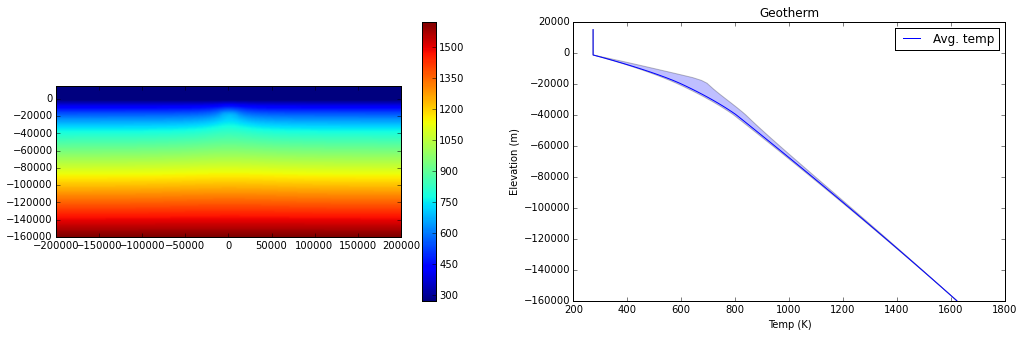

In [4]:
temp_2d = temperatureField.data.reshape((jres+1,ires+1))
mplt.figure(figsize=(17,5))
mplt.subplot(121)
mplt.imshow(temp_2d, 
            origin = 'lower',
            extent = (xmin, xmax, ymin, ymax))
mplt.colorbar()

mplt.subplot(122)
geotherm = np.average(temp_2d, axis=1)
geotherm_min = np.min(temp_2d, axis=1)
geotherm_max = np.max(temp_2d, axis=1)
depth = np.linspace(ymin, ymax, geotherm.shape[0])

mplt.plot(geotherm, depth, label = "Avg. temp")
mplt.fill_betweenx(depth, geotherm_min, geotherm_max, facecolor='blue', alpha=0.25)

mplt.title("Geotherm")
mplt.ylabel("Elevation (m)")
mplt.xlabel("Temp (K)")
mplt.legend(loc="best")

In [5]:
# Bit of a hack - we used the notch to make a hotspot - now we undo that by giving it the same
# properties as the upper crust.
radiogenic_heat_map[notchIndex] = radiogenic_heat_map[uppercrustIndex]

In [6]:
# Initialise data.
vel_init_fn_x = coord[0] / ((np.abs(xmax) - np.min(xmin))/2.) * 3.16887646e-10  # Guess that on the edges we'll be going about 1 cm/yr either direction
vel_init_fn_y = -(coord[1] - xmin) / ((np.abs(ymax) - np.min(ymin))) * 3.16887646e-10  # Since we have no isostasy, guess that at the bottom it's zero, and it increases above
velocityField.data[:] = np.hstack((vel_init_fn_x.evaluate(linearMesh), vel_init_fn_y.evaluate(linearMesh)))

sri_Fn = fn.tensor.second_invariant( 
                fn.tensor.deviatoric(
                    fn.tensor.symmetric ( 
                        velocityField.gradientFn )) )
strainRateInvField.data[:] = sri_Fn.evaluate(linearMesh)

velocityField.data[:] = [0,0]
strainRateInvField.data[:] = 1e-15

pseudopressure = -coord[1] * 9.81 * 3000.  # Take a guess at the pressure
pressureField.data[:] = pseudopressure.evaluate(constantMesh)
pressureField.data[pressureField.data <= 0.] = 1.  # Make everything > 0.

# Pre-exponential factor
A_map = {uppercrustIndex: 5e-24,         
         notchIndex: 5e-24,
         lowercrustIndex: 6.30957e-21,
         mantleIndex: 1.6e-18,}

# Stress exponent
n_map = {uppercrustIndex: 3.,
         notchIndex: 3.,
         lowercrustIndex: 3.2,
         mantleIndex: 3.5,}

# Grainsize
d_map = {uppercrustIndex: 0.,
         notchIndex: 0.,
         lowercrustIndex: 0.,
         mantleIndex: 10000.,}

# Grainsize exponent
p_map = {uppercrustIndex: 0.,
         notchIndex: 0.,
         lowercrustIndex: 0.,
         mantleIndex: 0.,}

# Water fugacity
fH20_map = {uppercrustIndex: 0.,
            notchIndex: 0.,
            lowercrustIndex: 0.,
            mantleIndex: 1000.,}

# Water fugacity exponent
r_map = {uppercrustIndex: 0.,
         notchIndex: 0.,
         lowercrustIndex: 0.,
         mantleIndex: 1.2,}

# Activation energy
E_map = {uppercrustIndex: 190e3,
         notchIndex: 190e3,
         lowercrustIndex: 244e3,
         mantleIndex: 520e3,}

# Activation volume
V_map = {uppercrustIndex: 0.,
         notchIndex: 0.,
         lowercrustIndex: 0.,
         mantleIndex: 23e-6,}

R = 8.314

A_Fn = fn.branching.map(keyFunc = material_index, mappingDict = A_map)
n_Fn = fn.branching.map(keyFunc = material_index, mappingDict = n_map)
d_Fn = fn.branching.map(keyFunc = material_index, mappingDict = d_map)
p_Fn = fn.branching.map(keyFunc = material_index, mappingDict = p_map)
fH20_Fn = fn.branching.map(keyFunc = material_index, mappingDict = fH20_map)
r_Fn = fn.branching.map(keyFunc = material_index, mappingDict = r_map)
E_Fn = fn.branching.map(keyFunc = material_index, mappingDict = E_map)
V_Fn = fn.branching.map(keyFunc = material_index, mappingDict = V_map)

In [7]:
non_newtonian_fn = 0.5 * fn.math.pow( A_Fn, -1. / n_Fn ) * \
                   fn.math.pow( strainRateInvField, (1. / n_Fn) - 1.) * \
                   fn.math.pow( d_Fn, p_Fn / n_Fn ) * \
                   fn.math.pow( fH20_Fn, -r_Fn / n_Fn ) * \
                   fn.math.exp( (E_Fn + pressureField * V_Fn) / (n_Fn * R * temperatureField))

#byerlee_fn = (0.75 * pressureField) / (2. * strainRateInvField)  # problems with pressurefield after stokes solve
byerlee_fn = (0.75 * (pseudopressure)) / (2. * strainRateInvField)

min_visc = 1e19

flow_visc_law_map = {airIndex: 1e19,
                     notchIndex: non_newtonian_fn,
                     uppercrustIndex: non_newtonian_fn,
                     lowercrustIndex: non_newtonian_fn,
                     mantleIndex: non_newtonian_fn,}
flow_visc_Fn = fn.branching.map(keyFunc = material_index, mappingDict = flow_visc_law_map)
"""
# This conditional function does NOT work, which makes me wonder why a similar function DOES work 
# for the thermal steady-state
flow_visc_Fn = fn.branching.conditional([
                         (material_index == airIndex, 1e18            ),
                         (True,                       non_newtonian_fn),])
"""

brittle_visc_law_map = {airIndex: 1e19,
                        notchIndex: byerlee_fn,
                        uppercrustIndex: byerlee_fn,
                        lowercrustIndex: byerlee_fn,
                        mantleIndex: byerlee_fn,}
brittle_visc_Fn = fn.branching.map(keyFunc = material_index, mappingDict = brittle_visc_law_map)

In [8]:
bench_data = {}

# Test each visc function

In [9]:
start = time.time()
visc.data[:] = flow_visc_Fn.evaluate(swarm)
bench_data["0. Visc law"] = time.time() - start

start = time.time()
visc.data[:] = brittle_visc_Fn.evaluate(swarm)
bench_data["0. Brit law"] = time.time() - start

In [10]:
print "Basic non-newtonian visc-law - time elapsed: {} s".format(bench_data["0. Visc law"])
print "Basic byerlee brittle-law - time elapsed: {} s".format(bench_data["0. Brit law"])

Basic non-newtonian visc-law - time elapsed: 14.4368071556 s
Basic byerlee brittle-law - time elapsed: 3.78438687325 s


# Version 1

In [18]:
# Choose which law to use - which one requires less energy:
visc_law_Fn = fn.branching.conditional([ (brittle_visc_Fn <= flow_visc_Fn, brittle_visc_Fn),
                                         (brittle_visc_Fn >  flow_visc_Fn, flow_visc_Fn),
                                         (True, 1e21) ]) # backup!

# Make sure the viscosity doesn't go too low
visc_limited_Fn = fn.branching.conditional([ (visc_law_Fn <= min_visc, min_visc),
                                             (visc_law_Fn >  min_visc, visc_law_Fn) ]) 

# Make sure the stresses stay realistic
stress_Fn = fn.tensor.deviatoric( 2. * visc_limited_Fn * fn.tensor.symmetric( velocityField.gradientFn ))
stress_limited_visc = uw.function.rheology.stress_limiting_viscosity(stress_Fn, 300e8, visc_limited_Fn)

# Make it complain if bath maths happens
viscosity_Fn = fn.exception.SafeMaths(stress_limited_visc)

# Version 2

In [11]:
# Choose which law to use - which one requires less energy:
visc_law_Fn_v2 = fn.misc.min(brittle_visc_Fn, flow_visc_Fn)

# Make sure the viscosity doesn't go too low
visc_limited_Fn_v2 = fn.misc.max(visc_law_Fn_v2, min_visc)

# Make sure the stresses stay realistic
stress_Fn_v2 = fn.tensor.deviatoric( 2. * visc_limited_Fn_v2 * fn.tensor.symmetric( velocityField.gradientFn ))
stress_limited_visc_v2 = uw.function.rheology.stress_limiting_viscosity(stress_Fn_v2, 300e8, visc_limited_Fn_v2)

# Make it complain if bath maths happens
viscosity_Fn_v2 = fn.exception.SafeMaths(stress_limited_visc_v2)

# Version 3

In [15]:
# Choose which law to use - which one requires less energy:
visc_law_Fn_v3 = fn.branching.conditional([ (brittle_visc_Fn <= flow_visc_Fn, brittle_visc_Fn),
                                            (True, flow_visc_Fn) ]) 

# Make sure the viscosity doesn't go too low
visc_limited_Fn_v3 = fn.branching.conditional([ (visc_law_Fn_v3 <= min_visc, min_visc),
                                                (True, visc_law_Fn_v3) ]) 

# Make sure the stresses stay realistic
stress_Fn_v3 = fn.tensor.deviatoric( 2. * visc_limited_Fn_v3 * fn.tensor.symmetric( velocityField.gradientFn ))
stress_limited_visc_v3 = uw.function.rheology.stress_limiting_viscosity(stress_Fn_v3, 300e8, visc_limited_Fn_v3)

# Make it complain if bath maths happens
viscosity_Fn_v3 = fn.exception.SafeMaths(stress_limited_visc_v3)

# Testing

In [19]:
start = time.time()
visc.data[:] = visc_law_Fn.evaluate(swarm)
bench_data["1.1"] = time.time() - start

start = time.time()
visc.data[:] = visc_limited_Fn.evaluate(swarm)
bench_data["1.2"] = time.time() - start

start = time.time()
visc.data[:] = stress_limited_visc.evaluate(swarm)
bench_data["1.3"] = time.time() - start

start = time.time()
visc.data[:] = viscosity_Fn.evaluate(swarm)
bench_data["1.4"] = time.time() - start

In [12]:
start = time.time()
visc.data[:] = visc_law_Fn_v2.evaluate(swarm)
bench_data["2.1"] = time.time() - start

start = time.time()
visc.data[:] = visc_limited_Fn_v2.evaluate(swarm)
bench_data["2.2"] = time.time() - start

start = time.time()
visc.data[:] = stress_limited_visc_v2.evaluate(swarm)
bench_data["2.3"] = time.time() - start

start = time.time()
visc.data[:] = viscosity_Fn_v2.evaluate(swarm)
bench_data["2.4"] = time.time() - start

In [16]:
start = time.time()
visc.data[:] = visc_law_Fn_v3.evaluate(swarm)
bench_data["3.1"] = time.time() - start

start = time.time()
visc.data[:] = visc_limited_Fn_v3.evaluate(swarm)
bench_data["3.2"] = time.time() - start

start = time.time()
visc.data[:] = stress_limited_visc_v3.evaluate(swarm)
bench_data["3.3"] = time.time() - start

start = time.time()
visc.data[:] = viscosity_Fn_v3.evaluate(swarm)
bench_data["3.4"] = time.time() - start

In [43]:
print "Combined brittle-visc law - time elapsed: {} s".format(bench_data["1.1"])
print "Combined brittle-visc law, min limited - time elapsed: {} s".format(bench_data["1.2"])
print "Combined brittle-visc law, min limited, stress limited - time elapsed: {} s".format(bench_data["1.3"])
print "Combined brittle-visc law, min limited, stress limited, safe maths - time elapsed: {} s".format(bench_data["1.4"])
print 
print "Combined brittle-visc law v2 - time elapsed: {} s".format(bench_data["2.1"])
print "Combined brittle-visc law, min limited v2 - time elapsed: {} s".format(bench_data["2.2"])
print "Combined brittle-visc law, min limited, stress limited v2 - time elapsed: {} s".format(bench_data["2.3"])
print "Combined brittle-visc law, min limited, stress limited, safe maths v2 - time elapsed: {} s".format(bench_data["2.4"])
print 
print "Combined brittle-visc law v3 - time elapsed: {} s".format(bench_data["3.1"])
print "Combined brittle-visc law, min limited v3 - time elapsed: {} s".format(bench_data["3.2"])
print "Combined brittle-visc law, min limited, stress limited v3 - time elapsed: {} s".format(bench_data["3.3"])
print "Combined brittle-visc law, min limited, stress limited, safe maths v3 - time elapsed: {} s".format(bench_data["3.4"])

Combined brittle-visc law - time elapsed: 46.8258528709 s
Combined brittle-visc law, min limited - time elapsed: 139.634763956 s
Combined brittle-visc law, min limited, stress limited - time elapsed: 286.500945091 s
Combined brittle-visc law, min limited, stress limited, safe maths - time elapsed: 285.274792194 s

Combined brittle-visc law v2 - time elapsed: 18.5005230904 s
Combined brittle-visc law, min limited v2 - time elapsed: 19.1375980377 s
Combined brittle-visc law, min limited, stress limited v2 - time elapsed: 42.8818640709 s
Combined brittle-visc law, min limited, stress limited, safe maths v2 - time elapsed: 42.9476718903 s

Combined brittle-visc law v3 - time elapsed: 30.855848074 s
Combined brittle-visc law, min limited v3 - time elapsed: 62.9309539795 s
Combined brittle-visc law, min limited, stress limited v3 - time elapsed: 131.529258013 s
Combined brittle-visc law, min limited, stress limited, safe maths v3 - time elapsed: 132.387403011 s


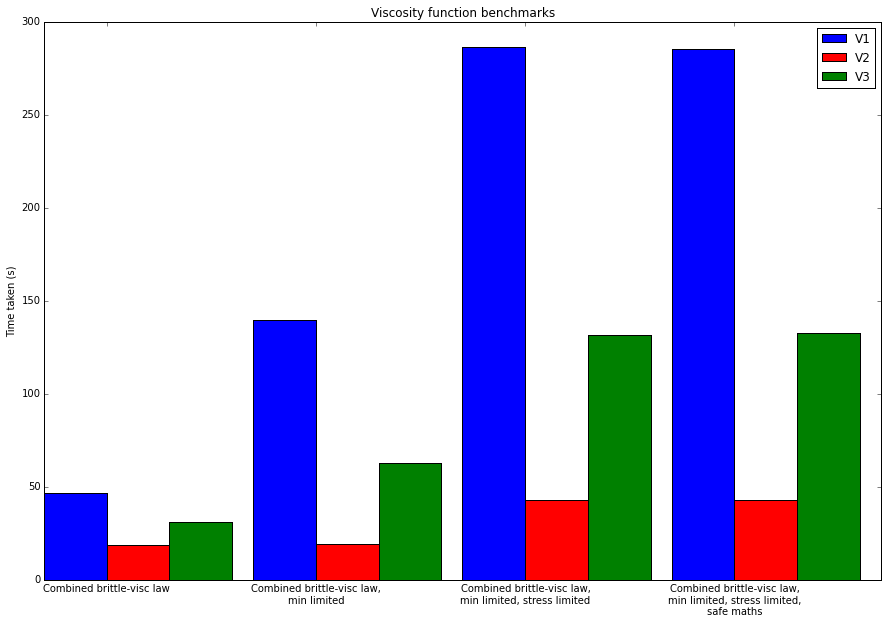

In [44]:
N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars
fig, ax = mplt.subplots(figsize=(15,10))
colours = ['b', 'r', 'g']
for i in range(1,4):
    times = [value for key, value in sorted(bench_data.iteritems(), key = lambda x: x[0]) if key.startswith(str(i))]
    rects = ax.bar(ind + ((i-1) * width), times, width, color=colours[i-1], label = "V{}".format(i))

ax.set_ylabel('Time taken (s)')
ax.set_title('Viscosity function benchmarks')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('Combined brittle-visc law', 
                     'Combined brittle-visc law,\nmin limited', 
                     'Combined brittle-visc law,\nmin limited, stress limited', 
                     'Combined brittle-visc law,\nmin limited, stress limited,\nsafe maths',));
ax.legend();